In [2]:
from __future__ import annotations

import argparse
import importlib.util
import os
import random
import subprocess
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple


def ensure_dependencies() -> None:
    required = {
        "kagglehub": "kagglehub",
        "grad-cam": "pytorch_grad_cam",
        "scikit-learn": "sklearn",
        "matplotlib": "matplotlib",
        "Pillow": "PIL",
        "torchvision": "torchvision",
    }
    missing = [pkg for pkg, mod in required.items() if importlib.util.find_spec(mod) is None]
    if missing:
        print(f"Installing missing packages: {missing}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *missing])


ensure_dependencies()

Installing missing packages: ['grad-cam']


In [3]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [4]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

CLASS_ALIASES = {
    "colon_aca": "Colon_aca",
    "colon_n": "Colon_n",
    "lung_aca": "Lung_aca",
    "lung_n": "Lung_n",
    "lung_scc": "Lung_scc",
}
LC25000_CLASSES = ["Colon_aca", "Colon_n", "Lung_aca", "Lung_n", "Lung_scc"]
CLASS_TO_IDX = {name: idx for idx, name in enumerate(LC25000_CLASSES)}

In [5]:
@dataclass
class Config:
    data_root: Optional[str] = None
    kaggle_dataset: str = "andrewmvd/lung-and-colon-cancer-histopathological-images"
    batch_size: int = 64
    num_workers: int = 2
    test_size: float = 0.2
    seed: int = 42
    cam_epochs: int = 2
    cam_lr: float = 1e-3
    sample_image: Optional[str] = None


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def is_image_file(path: Path) -> bool:
    return path.suffix.lower() in {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}


def find_lc25000_root(base_path: str) -> str:
    base = Path(base_path)
    expected = set(CLASS_ALIASES.keys())
    found = set()
    for current_root, dirnames, _ in os.walk(base):
        lowered = {d.lower() for d in dirnames}
        found.update(lowered.intersection(expected))
        if expected.issubset(found):
            return base_path
    raise FileNotFoundError(
        f"Could not find LC25000 class folders under: {base_path}. "
        "Expected folders: colon_aca, colon_n, lung_aca, lung_n, lung_scc. "
        f"Found only: {sorted(found)}"
    )

In [6]:
def download_lc25000_from_kagglehub(dataset_slug: str) -> str:
    print(f"Downloading dataset from KaggleHub: {dataset_slug}")
    download_path = kagglehub.dataset_download(dataset_slug)
    print(f"KaggleHub cache path: {download_path}")
    lc_root = find_lc25000_root(download_path)
    print(f"Detected LC25000 image root: {lc_root}")
    return lc_root


class LC25000Dataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose) -> None:
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples: List[Tuple[str, int]] = []
        self._scan()

    def _scan(self) -> None:
        for current_root, _, filenames in os.walk(self.root_dir):
            folder_name = Path(current_root).name.lower()
            if folder_name not in CLASS_ALIASES:
                continue
            class_name = CLASS_ALIASES[folder_name]
            class_idx = CLASS_TO_IDX[class_name]
            for file_name in filenames:
                img_path = Path(current_root) / file_name
                if is_image_file(img_path):
                    self.samples.append((str(img_path), class_idx))

        if not self.samples:
            raise RuntimeError(
                f"No images found under {self.root_dir}. "
                "Check that LC25000 was downloaded and extracted correctly."
            )

        print(f"Total images found: {len(self.samples)}")
        class_counts = {name: 0 for name in LC25000_CLASSES}
        for _, cls_idx in self.samples:
            class_counts[LC25000_CLASSES[cls_idx]] += 1
        print(f"Class distribution: {class_counts}")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path, label = self.samples[index]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, label

In [7]:
def build_transforms() -> transforms.Compose:
    return transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ]
    )


def build_dataloaders(
    cfg: Config, dataset: LC25000Dataset
) -> Tuple[DataLoader, DataLoader, Sequence[int], Sequence[int]]:
    labels = np.array([label for _, label in dataset.samples])
    indices = np.arange(len(dataset))
    train_idx, test_idx = train_test_split(
        indices,
        test_size=cfg.test_size,
        random_state=cfg.seed,
        stratify=labels,
    )

    train_dataset = Subset(dataset, train_idx.tolist())
    test_dataset = Subset(dataset, test_idx.tolist())

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    return train_loader, test_loader, train_idx, test_idx


def build_feature_extractor(device: torch.device) -> nn.Module:
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = nn.Identity()
    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    return model


def extract_features(
    model: nn.Module, loader: DataLoader, device: torch.device
) -> Tuple[np.ndarray, np.ndarray]:
    all_features: List[np.ndarray] = []
    all_labels: List[np.ndarray] = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            feats = model(images)
            all_features.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)


In [8]:
def train_linear_svm(x_train: np.ndarray, y_train: np.ndarray) -> SVC:
    svm = SVC(kernel="linear", probability=True, random_state=42)
    svm.fit(x_train, y_train)
    return svm


def evaluate_svm(svm: SVC, x_test: np.ndarray, y_test: np.ndarray) -> None:
    y_pred = svm.predict(x_test)
    print("\nClassification Report")
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=LC25000_CLASSES,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, cmap="Blues")
    plt.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(LC25000_CLASSES)),
        yticks=np.arange(len(LC25000_CLASSES)),
        xticklabels=LC25000_CLASSES,
        yticklabels=LC25000_CLASSES,
        xlabel="Predicted label",
        ylabel="True label",
        title="Confusion Matrix (Linear SVM on ResNet50 Features)",
    )
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")
    threshold = cm.max() / 2 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                str(cm[i, j]),
                ha="center",
                va="center",
                color="white" if cm[i, j] > threshold else "black",
            )
    fig.tight_layout()
    plt.show()


class ResNetCamModel(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)  # logits


def train_cam_model(
    train_loader: DataLoader,
    num_classes: int,
    device: torch.device,
    epochs: int = 2,
    lr: float = 1e-3,
) -> nn.Module:
    model = ResNetCamModel(num_classes=num_classes).to(device)
    for name, p in model.named_parameters():
        if "backbone.fc" not in name:
            p.requires_grad = False

    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"CAM head epoch {epoch + 1}/{epochs} - loss: {epoch_loss / max(len(train_loader), 1):.4f}")

    model.eval()
    return model

Ignoring unrecognized notebook/launcher args: ['-f', '/root/.local/share/jupyter/runtime/kernel-16d9872e-c442-42dc-8140-e806139c75b1.json']
Using device: cuda
Using Colab cache for faster access to the 'lung-and-colon-cancer-histopathological-images' dataset.
KaggleHub cache path: /kaggle/input/lung-and-colon-cancer-histopathological-images
Detected LC25000 image root: /kaggle/input/lung-and-colon-cancer-histopathological-images
Total images found: 25000
Class distribution: {'Colon_aca': 5000, 'Colon_n': 5000, 'Lung_aca': 5000, 'Lung_n': 5000, 'Lung_scc': 5000}
Building frozen ResNet50 feature extractor...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


Extracting train features...
Extracting test features...
Feature shape - train: (20000, 2048), test: (5000, 2048)
Training linear SVM...

Classification Report
              precision    recall  f1-score   support

   Colon_aca     1.0000    0.9990    0.9995      1000
     Colon_n     0.9980    1.0000    0.9990      1000
    Lung_aca     0.9840    0.9860    0.9850      1000
      Lung_n     1.0000    1.0000    1.0000      1000
    Lung_scc     0.9870    0.9840    0.9855      1000

    accuracy                         0.9938      5000
   macro avg     0.9938    0.9938    0.9938      5000
weighted avg     0.9938    0.9938    0.9938      5000



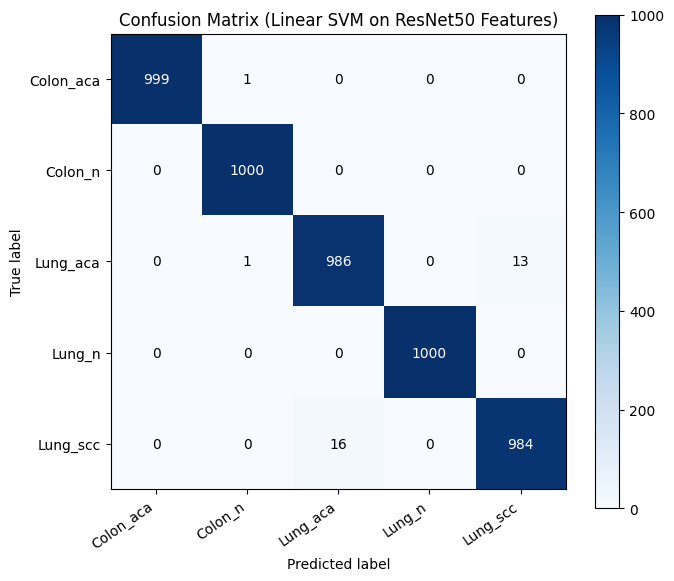

Training lightweight CAM classifier head...
CAM head epoch 1/2 - loss: 0.3028
CAM head epoch 2/2 - loss: 0.1097
Generating Grad-CAM for: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca4547.jpeg


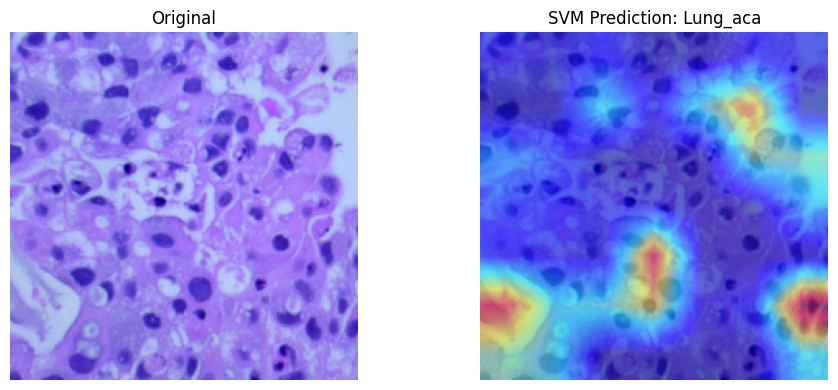

In [9]:
def denormalize(image_tensor: torch.Tensor) -> np.ndarray:
    img = image_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    return np.clip(img, 0, 1).astype(np.float32)


def pick_sample_image_path(
    dataset: LC25000Dataset, test_indices: Sequence[int], sample_image: Optional[str]
) -> str:
    if sample_image is not None:
        return sample_image
    first_idx = int(test_indices[0])
    return dataset.samples[first_idx][0]


def visualize_prediction_with_gradcam(
    image_path: str,
    feature_extractor: nn.Module,
    svm: SVC,
    cam_model: nn.Module,
    device: torch.device,
) -> None:
    preprocess = build_transforms()
    pil_img = Image.open(image_path).convert("RGB")
    x = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = feature_extractor(x).cpu().numpy()
    pred_idx = int(svm.predict(feat)[0])
    pred_name = LC25000_CLASSES[pred_idx]
    for p in cam_model.backbone.layer4.parameters():
        p.requires_grad = True
    cam_model.zero_grad(set_to_none=True)
    x_for_cam = x.detach().clone().requires_grad_(True)

    target_layer = cam_model.backbone.layer4[-1]
    with GradCAM(model=cam_model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(
            input_tensor=x_for_cam,
            targets=[ClassifierOutputTarget(pred_idx)],
        )[0]

    original = denormalize(x[0])
    overlay = show_cam_on_image(original, grayscale_cam, use_rgb=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(overlay)
    axes[1].set_title(f"SVM Prediction: {pred_name}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()


def resolve_data_root(cfg: Config) -> str:
    if cfg.data_root and os.path.isdir(cfg.data_root):
        root = find_lc25000_root(cfg.data_root)
        print(f"Using provided dataset path: {root}")
        return root
    return download_lc25000_from_kagglehub(cfg.kaggle_dataset)


def run_pipeline(cfg: Config) -> None:
    set_seed(cfg.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    data_root = resolve_data_root(cfg)
    dataset = LC25000Dataset(root_dir=data_root, transform=build_transforms())
    train_loader, test_loader, _, test_indices = build_dataloaders(cfg, dataset)

    print("Building frozen ResNet50 feature extractor...")
    feature_extractor = build_feature_extractor(device)

    print("Extracting train features...")
    x_train, y_train = extract_features(feature_extractor, train_loader, device)
    print("Extracting test features...")
    x_test, y_test = extract_features(feature_extractor, test_loader, device)
    print(f"Feature shape - train: {x_train.shape}, test: {x_test.shape}")

    print("Training linear SVM...")
    svm = train_linear_svm(x_train, y_train)
    evaluate_svm(svm, x_test, y_test)

    print("Training lightweight CAM classifier head...")
    cam_model = train_cam_model(
        train_loader=train_loader,
        num_classes=len(LC25000_CLASSES),
        device=device,
        epochs=cfg.cam_epochs,
        lr=cfg.cam_lr,
    )

    sample_path = pick_sample_image_path(dataset, test_indices, cfg.sample_image)
    print(f"Generating Grad-CAM for: {sample_path}")
    visualize_prediction_with_gradcam(
        image_path=sample_path,
        feature_extractor=feature_extractor,
        svm=svm,
        cam_model=cam_model,
        device=device,
    )


def parse_args() -> Config:
    parser = argparse.ArgumentParser(
        description="End-to-end LC25000 hybrid pipeline for Google Colab."
    )
    parser.add_argument(
        "--data_root",
        type=str,
        default=None,
        help="Optional local root path. If omitted, auto-download via kagglehub.",
    )
    parser.add_argument(
        "--kaggle_dataset",
        type=str,
        default="andrewmvd/lung-and-colon-cancer-histopathological-images",
        help="Kaggle dataset slug for LC25000.",
    )
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--num_workers", type=int, default=2)
    parser.add_argument("--test_size", type=float, default=0.2)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--cam_epochs", type=int, default=2)
    parser.add_argument("--cam_lr", type=float, default=1e-3)
    parser.add_argument("--sample_image", type=str, default=None)
    args, unknown = parser.parse_known_args()
    if unknown:
        print(f"Ignoring unrecognized notebook/launcher args: {unknown}")
    return Config(
        data_root=args.data_root,
        kaggle_dataset=args.kaggle_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        test_size=args.test_size,
        seed=args.seed,
        cam_epochs=args.cam_epochs,
        cam_lr=args.cam_lr,
        sample_image=args.sample_image,
    )


if __name__ == "__main__":
    cfg = parse_args()
    run_pipeline(cfg)
